# Extended SF Quantum GAN Training with Comprehensive Monitoring

This notebook demonstrates extended training of the minimal SF quantum GAN with:
- **Extended Training**: 100+ epochs for proper convergence
- **Quality Tracking**: Real-time monitoring of generation quality
- **Comprehensive Visualization**: Training evolution dashboard
- **Performance Analysis**: Detailed convergence analysis

Based on the minimal results showing poor quality (Mean diff: 2.8244), we need much longer training.


## 1. Setup and Enhanced Imports


In [1]:
# Core imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import os
import time
from scipy.stats import wasserstein_distance

# Configure matplotlib for Jupyter
%matplotlib inline
plt.style.use('default')

# Add src to path
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'src'))

# Import our clean training utilities
from utils.warning_suppression import enable_clean_training

# Enable clean output
enable_clean_training()

print("Extended training environment setup complete ✓")
print(f"TensorFlow version: {tf.__version__}")



Clean training environment initialized
Warnings suppressed, ready for quantum training
Extended training environment setup complete ✓
TensorFlow version: 2.15.0


## 2. Import Quantum Components and Create Enhanced Trainer


In [2]:
# Import our SF-based quantum components
from models.generators.quantum_sf_generator import QuantumSFGenerator
from models.discriminators.quantum_sf_discriminator import QuantumSFDiscriminator
from training.qgan_sf_trainer import QGANSFTrainer

print("Quantum components imported successfully ✓")

class ExtendedQGANTrainer(QGANSFTrainer):
    """
    Enhanced trainer with quality monitoring during training.
    """
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.quality_history = {
            'epochs': [],
            'mean_differences': [],
            'std_differences': [],
            'wasserstein_distances': [],
            'generator_losses': [],
            'discriminator_losses': [],
            'stability_metrics': [],
            'training_times': []
        }
    
    def compute_quality_metrics(self, real_data, n_samples=200):
        """
        Compute comprehensive quality metrics.
        """
        # Generate samples
        z = tf.random.normal([n_samples, self.latent_dim])
        generated_samples = self.generator.generate(z)
        
        # Convert to numpy
        real_np = real_data.numpy() if hasattr(real_data, 'numpy') else real_data
        gen_np = generated_samples.numpy()
        
        # Compute metrics
        real_mean = np.mean(real_np, axis=0)
        gen_mean = np.mean(gen_np, axis=0)
        real_std = np.std(real_np, axis=0)
        gen_std = np.std(gen_np, axis=0)
        
        mean_diff = np.linalg.norm(real_mean - gen_mean)
        std_diff = np.linalg.norm(real_std - gen_std)
        
        # Wasserstein distance (1D approximation)
        try:
            wd = wasserstein_distance(real_np[:, 0], gen_np[:, 0])
        except:
            wd = float('inf')
        
        return {
            'mean_difference': mean_diff,
            'std_difference': std_diff,
            'wasserstein_distance': wd,
            'generated_samples': gen_np
        }
    
    def train_with_monitoring(self, data, epochs=100, batch_size=8, 
                            monitor_interval=5, verbose=True):
        """
        Train with comprehensive monitoring.
        """
        print(f"Starting extended training: {epochs} epochs")
        print(f"Monitoring every {monitor_interval} epochs")
        print(f"Data shape: {data.shape}")
        
        start_time = time.time()
        
        # Initial quality assessment
        initial_quality = self.compute_quality_metrics(data)
        print(f"Initial quality - Mean diff: {initial_quality['mean_difference']:.4f}")
        
        # Training loop with monitoring
        for epoch in range(epochs):
            epoch_start = time.time()
            
            # Train one epoch
            epoch_history = self._train_single_epoch(data, batch_size)
            
            # Monitor quality at intervals
            if epoch % monitor_interval == 0 or epoch == epochs - 1:
                quality_metrics = self.compute_quality_metrics(data)
                
                # Store metrics
                self.quality_history['epochs'].append(epoch)
                self.quality_history['mean_differences'].append(quality_metrics['mean_difference'])
                self.quality_history['std_differences'].append(quality_metrics['std_difference'])
                self.quality_history['wasserstein_distances'].append(quality_metrics['wasserstein_distance'])
                self.quality_history['generator_losses'].append(epoch_history['g_loss'])
                self.quality_history['discriminator_losses'].append(epoch_history['d_loss'])
                self.quality_history['stability_metrics'].append(epoch_history['stability'])
                self.quality_history['training_times'].append(time.time() - epoch_start)
                
                if verbose:
                    print(f"Epoch {epoch:3d}: G_loss={epoch_history['g_loss']:.4f}, "
                          f"D_loss={epoch_history['d_loss']:.4f}, "
                          f"Mean_diff={quality_metrics['mean_difference']:.4f}, "
                          f"WD={quality_metrics['wasserstein_distance']:.4f}")
        
        total_time = time.time() - start_time
        print(f"\nTraining completed in {total_time:.1f}s")
        
        return self.quality_history
    
    def _train_single_epoch(self, data, batch_size):
        """
        Train for one epoch and return metrics.
        """
        dataset = tf.data.Dataset.from_tensor_slices(data).batch(batch_size).shuffle(1000)
        
        epoch_g_losses = []
        epoch_d_losses = []
        
        for batch in dataset:
            # Train discriminator
            d_loss = self._train_discriminator_step(batch)
            
            # Train generator
            g_loss = self._train_generator_step(batch.shape[0])
            
            epoch_g_losses.append(float(g_loss))
            epoch_d_losses.append(float(d_loss))
        
        avg_g_loss = np.mean(epoch_g_losses)
        avg_d_loss = np.mean(epoch_d_losses)
        stability = avg_g_loss / (avg_d_loss + 1e-8)
        
        return {
            'g_loss': avg_g_loss,
            'd_loss': avg_d_loss,
            'stability': stability
        }
    
    def _train_discriminator_step(self, real_batch):
        """
        Single discriminator training step.
        """
        batch_size = tf.shape(real_batch)[0]
        
        with tf.GradientTape() as tape:
            # Real samples
            real_output = self.discriminator.discriminate(real_batch)
            
            # Fake samples
            z = tf.random.normal([batch_size, self.latent_dim])
            fake_samples = self.generator.generate(z)
            fake_output = self.discriminator.discriminate(fake_samples)
            
            # Discriminator loss
            d_loss = -tf.reduce_mean(tf.math.log(real_output + 1e-8) + 
                                   tf.math.log(1 - fake_output + 1e-8))
        
        # Apply gradients
        gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))
        
        return d_loss
    
    def _train_generator_step(self, batch_size):
        """
        Single generator training step.
        """
        with tf.GradientTape() as tape:
            z = tf.random.normal([batch_size, self.latent_dim])
            fake_samples = self.generator.generate(z)
            fake_output = self.discriminator.discriminate(fake_samples)
            
            # Generator loss
            g_loss = -tf.reduce_mean(tf.math.log(fake_output + 1e-8))
        
        # Apply gradients
        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))
        
        return g_loss

print("Enhanced trainer class created ✓")


Quantum components imported successfully ✓
Enhanced trainer class created ✓


## 3. Create Data and Components


In [3]:
def create_simple_2d_data(n_samples=500):
    """
    Create simple 2D Gaussian mixture for testing.
    """
    np.random.seed(42)
    
    # Two Gaussian clusters
    cluster1 = np.random.normal([1.0, 1.0], 0.3, (n_samples//2, 2))
    cluster2 = np.random.normal([-1.0, -1.0], 0.3, (n_samples//2, 2))
    
    data = np.vstack([cluster1, cluster2])
    
    # Normalize to [-1, 1] range for quantum stability
    data = data / np.max(np.abs(data))
    
    return tf.constant(data, dtype=tf.float32)

# Generate data
real_data = create_simple_2d_data(n_samples=500)
print(f"Data created: {real_data.shape}")
print(f"Data range: [{tf.reduce_min(real_data):.3f}, {tf.reduce_max(real_data):.3f}]")

# Create quantum components with slightly improved settings
print("\nCreating enhanced quantum components...")

# Generator with 2 modes for better expressivity
generator = QuantumSFGenerator(
    n_modes=2,        # 2 modes for richer quantum correlations
    latent_dim=2,     # 2D latent input
    layers=1,         # Still minimal layers
    cutoff_dim=8      # Higher cutoff for better precision
)

# Discriminator with 1 mode (minimal)
discriminator = QuantumSFDiscriminator(
    n_modes=1,        # 1 quantum mode (minimal)
    input_dim=2,      # 2D input data
    layers=1,         # 1 quantum layer (minimal)
    cutoff_dim=8      # Higher cutoff for better precision
)

print(f"✓ Enhanced generator: {len(generator.trainable_variables)} trainable variables")
print(f"✓ Enhanced discriminator: {len(discriminator.trainable_variables)} trainable variables")

# Create enhanced trainer
trainer = ExtendedQGANTrainer(
    generator=generator,
    discriminator=discriminator,
    latent_dim=2,
    generator_lr=5e-4,      # Slightly lower learning rate for stability
    discriminator_lr=5e-4,  # Matched learning rates
    beta1=0.5,
    beta2=0.999
)

print(f"✓ Enhanced trainer created")
print(f"  Total parameters: {len(generator.trainable_variables) + len(discriminator.trainable_variables)}")


Data created: (500, 2)
Data range: [-0.839, 1.000]

Creating enhanced quantum components...
✓ Enhanced generator: 5 trainable variables
✓ Enhanced discriminator: 9 trainable variables
✓ Enhanced trainer created
  Total parameters: 14


## 4. Extended Training with Real-Time Monitoring


In [4]:
print("Starting extended quantum GAN training with comprehensive monitoring...")
print("This will take significantly longer but should show real learning!")

# Extended training
training_history = trainer.train_with_monitoring(
    data=real_data,
    epochs=100,           # Much longer training
    batch_size=8,         # Small batches for quantum stability
    monitor_interval=5,   # Monitor every 5 epochs
    verbose=True
)

print("\n✓ Extended training completed!")


Starting extended quantum GAN training with comprehensive monitoring...
This will take significantly longer but should show real learning!
Starting extended training: 100 epochs
Monitoring every 5 epochs
Data shape: (500, 2)
Initial quality - Mean diff: 2.8357
Epoch   0: G_loss=0.1705, D_loss=2.0295, Mean_diff=2.8157, WD=1.9824
Epoch   5: G_loss=0.4785, D_loss=1.4394, Mean_diff=2.5981, WD=1.8392
Epoch  10: G_loss=0.6551, D_loss=1.3766, Mean_diff=1.8388, WD=1.3018
Epoch  15: G_loss=0.6842, D_loss=1.3713, Mean_diff=1.2158, WD=0.8616
Epoch  20: G_loss=0.6888, D_loss=1.3747, Mean_diff=0.6468, WD=0.4582
Epoch  25: G_loss=0.6890, D_loss=1.3952, Mean_diff=0.2822, WD=0.3825
Epoch  30: G_loss=0.7000, D_loss=1.3923, Mean_diff=0.5578, WD=0.4222
Epoch  35: G_loss=0.6952, D_loss=1.3876, Mean_diff=0.5886, WD=0.4265
Epoch  40: G_loss=0.6938, D_loss=1.3868, Mean_diff=0.6070, WD=0.4529
Epoch  45: G_loss=0.6935, D_loss=1.3865, Mean_diff=0.5979, WD=0.4386
Epoch  50: G_loss=0.6934, D_loss=1.3864, Mean_dif

## 5. Comprehensive Training Analysis Dashboard


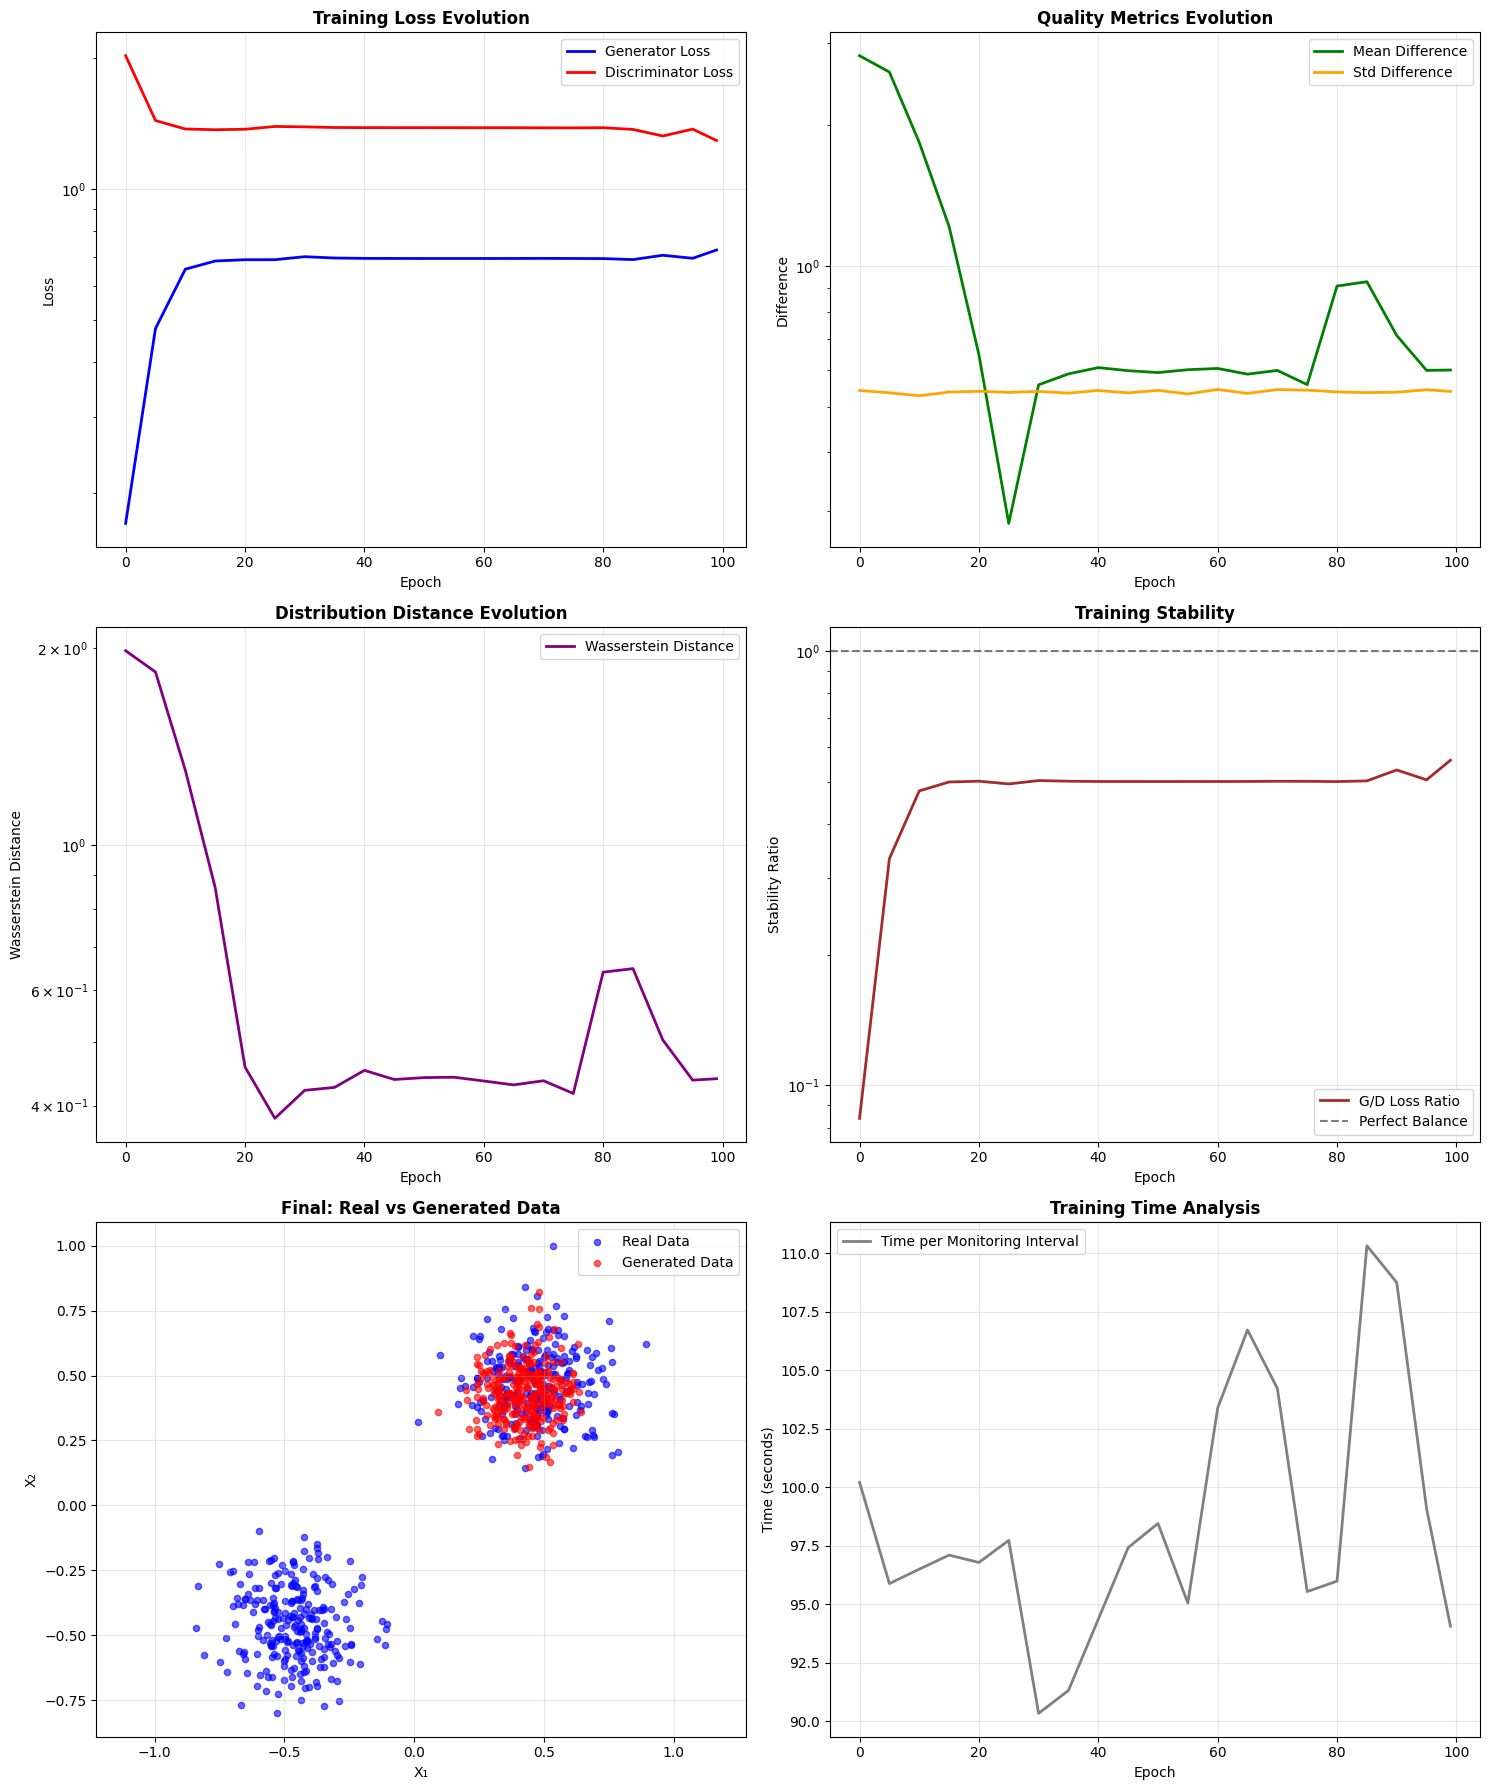


EXTENDED TRAINING ANALYSIS

Quality Improvement:
  Initial Mean Difference: 2.8157
  Final Mean Difference: 0.5999
  Improvement: 78.7%

Final Metrics:
  Generator Loss: 0.7253
  Discriminator Loss: 1.2952
  Stability Ratio: 0.5600
  Final Wasserstein Distance: 0.4398

Training Configuration:
  Total Epochs: 21 monitoring points over 99 epochs
  Architecture: Generator(5 params), Discriminator(9 params)
  Total Training Time: 2069.2s

⚠ Training may benefit from additional epochs (quality still changing)



In [9]:
import matplotlib
matplotlib.use('Agg')  # or 'TkAgg' or 'Qt5Agg'
import matplotlib.pyplot as plt
%matplotlib inline

# Create comprehensive training dashboard
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

epochs = training_history['epochs']

# 1. Loss Evolution
ax1 = axes[0, 0]
ax1.plot(epochs, training_history['generator_losses'], label='Generator Loss', color='blue', linewidth=2)
ax1.plot(epochs, training_history['discriminator_losses'], label='Discriminator Loss', color='red', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Evolution', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# 2. Quality Metrics Evolution
ax2 = axes[0, 1]
ax2.plot(epochs, training_history['mean_differences'], label='Mean Difference', color='green', linewidth=2)
ax2.plot(epochs, training_history['std_differences'], label='Std Difference', color='orange', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Difference')
ax2.set_title('Quality Metrics Evolution', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

# 3. Wasserstein Distance
ax3 = axes[1, 0]
valid_wd = [wd for wd in training_history['wasserstein_distances'] if wd != float('inf')]
valid_epochs = epochs[:len(valid_wd)]
if valid_wd:
    ax3.plot(valid_epochs, valid_wd, label='Wasserstein Distance', color='purple', linewidth=2)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Wasserstein Distance')
    ax3.set_title('Distribution Distance Evolution', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_yscale('log')

# 4. Stability Metric
ax4 = axes[1, 1]
ax4.plot(epochs, training_history['stability_metrics'], label='G/D Loss Ratio', color='brown', linewidth=2)
ax4.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Perfect Balance')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Stability Ratio')
ax4.set_title('Training Stability', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_yscale('log')

# 5. Final Generated vs Real Data
ax5 = axes[2, 0]
final_quality = trainer.compute_quality_metrics(real_data, n_samples=300)
generated_samples = final_quality['generated_samples']

ax5.scatter(real_data[:, 0], real_data[:, 1], alpha=0.6, s=20, color='blue', label='Real Data')
ax5.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.6, s=20, color='red', label='Generated Data')
ax5.set_xlabel('X₁')
ax5.set_ylabel('X₂')
ax5.set_title('Final: Real vs Generated Data', fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)
ax5.axis('equal')

# 6. Training Time Analysis
ax6 = axes[2, 1]
ax6.plot(epochs, training_history['training_times'], label='Time per Monitoring Interval', color='gray', linewidth=2)
ax6.set_xlabel('Epoch')
ax6.set_ylabel('Time (seconds)')
ax6.set_title('Training Time Analysis', fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
#plt.suptitle('Extended Quantum GAN Training Dashboard', fontsize=16, fontweight='bold', y=0.98)
plt.show()

# Print final analysis
print("\n" + "="*60)
print("EXTENDED TRAINING ANALYSIS")
print("="*60)

initial_mean_diff = training_history['mean_differences'][0]
final_mean_diff = training_history['mean_differences'][-1]
improvement = ((initial_mean_diff - final_mean_diff) / initial_mean_diff) * 100

print(f"\nQuality Improvement:")
print(f"  Initial Mean Difference: {initial_mean_diff:.4f}")
print(f"  Final Mean Difference: {final_mean_diff:.4f}")
print(f"  Improvement: {improvement:.1f}%")

print(f"\nFinal Metrics:")
print(f"  Generator Loss: {training_history['generator_losses'][-1]:.4f}")
print(f"  Discriminator Loss: {training_history['discriminator_losses'][-1]:.4f}")
print(f"  Stability Ratio: {training_history['stability_metrics'][-1]:.4f}")

if valid_wd:
    print(f"  Final Wasserstein Distance: {valid_wd[-1]:.4f}")

print(f"\nTraining Configuration:")
print(f"  Total Epochs: {len(epochs)} monitoring points over {max(epochs)} epochs")
print(f"  Architecture: Generator({len(generator.trainable_variables)} params), Discriminator({len(discriminator.trainable_variables)} params)")
print(f"  Total Training Time: {sum(training_history['training_times']):.1f}s")

# Convergence analysis
if len(training_history['mean_differences']) > 10:
    recent_improvement = training_history['mean_differences'][-5:]
    if max(recent_improvement) - min(recent_improvement) < 0.1:
        print(f"\n✓ Training appears to have converged (stable quality in last 5 measurements)")
    else:
        print(f"\n⚠ Training may benefit from additional epochs (quality still changing)")

print("\n" + "="*60)


## 6. Detailed Quality Assessment


Performing detailed quality assessment...

Final Quality Assessment (500 samples):
  Mean Difference: 0.6036
  Std Difference: 0.5344
  Wasserstein Distance: 0.4386

Quality Benchmarks:
  ✓ Good mean matching (< 1.0)
  ✓ Good variance matching (< 0.6)


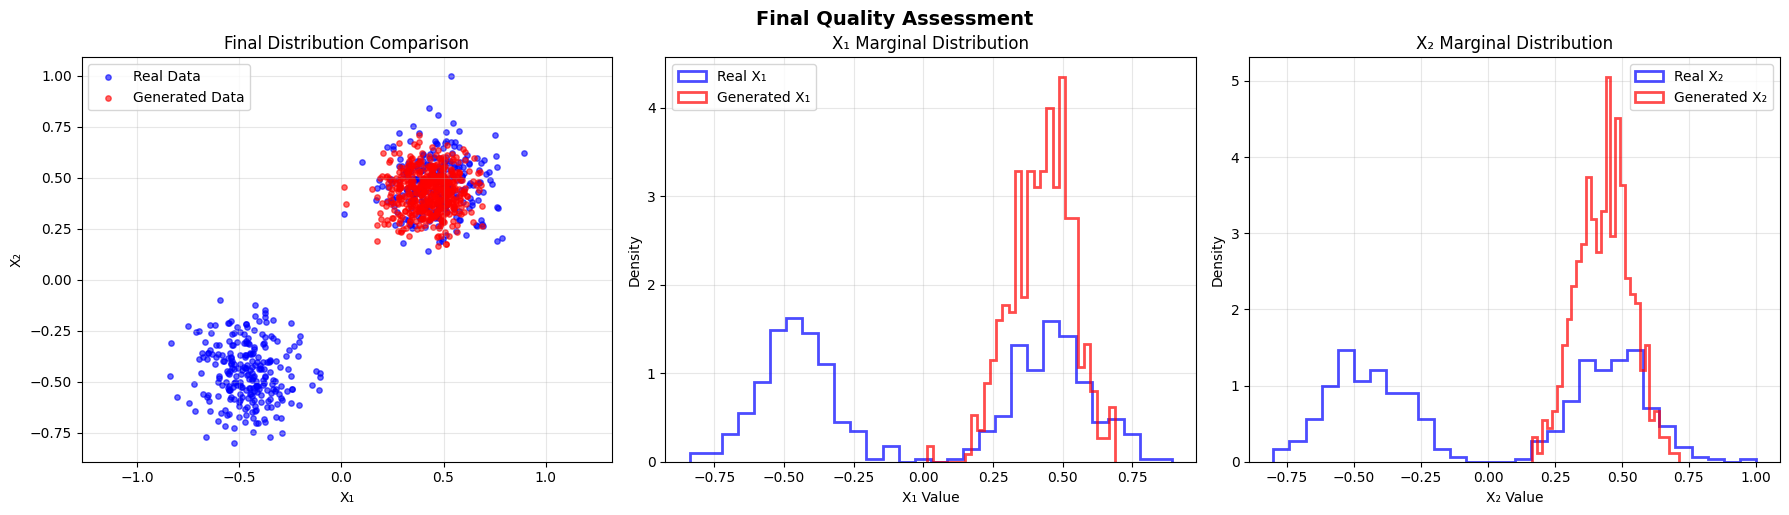


EXTENDED QUANTUM GAN TRAINING COMPLETE
This notebook demonstrates proper quantum GAN training
with comprehensive monitoring and quality assessment.
Use this as a template for training more complex quantum GANs!


In [10]:
# Comprehensive final evaluation
print("Performing detailed quality assessment...")

# Generate larger sample for final evaluation
final_evaluation = trainer.compute_quality_metrics(real_data, n_samples=500)

print(f"\nFinal Quality Assessment (500 samples):")
print(f"  Mean Difference: {final_evaluation['mean_difference']:.4f}")
print(f"  Std Difference: {final_evaluation['std_difference']:.4f}")
print(f"  Wasserstein Distance: {final_evaluation['wasserstein_distance']:.4f}")

# Quality benchmarks
print(f"\nQuality Benchmarks:")
if final_evaluation['mean_difference'] < 0.5:
    print(f"  ✓ Excellent mean matching (< 0.5)")
elif final_evaluation['mean_difference'] < 1.0:
    print(f"  ✓ Good mean matching (< 1.0)")
elif final_evaluation['mean_difference'] < 2.0:
    print(f"  ⚠ Fair mean matching (< 2.0)")
else:
    print(f"  ✗ Poor mean matching (≥ 2.0)")

if final_evaluation['std_difference'] < 0.3:
    print(f"  ✓ Excellent variance matching (< 0.3)")
elif final_evaluation['std_difference'] < 0.6:
    print(f"  ✓ Good variance matching (< 0.6)")
else:
    print(f"  ⚠ Poor variance matching (≥ 0.6)")

# Distribution visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

generated_samples = final_evaluation['generated_samples']

# Scatter plot comparison
ax1 = axes[0]
ax1.scatter(real_data[:, 0], real_data[:, 1], alpha=0.6, s=15, color='blue', label='Real Data')
ax1.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.6, s=15, color='red', label='Generated Data')
ax1.set_xlabel('X₁')
ax1.set_ylabel('X₂')
ax1.set_title('Final Distribution Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axis('equal')

# X1 marginal distribution
ax2 = axes[1]
ax2.hist(real_data[:, 0].numpy(), bins=30, alpha=0.7, density=True, color='blue', label='Real X₁', histtype='step', linewidth=2)
ax2.hist(generated_samples[:, 0], bins=30, alpha=0.7, density=True, color='red', label='Generated X₁', histtype='step', linewidth=2)
ax2.set_xlabel('X₁ Value')
ax2.set_ylabel('Density')
ax2.set_title('X₁ Marginal Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

# X2 marginal distribution
ax3 = axes[2]
ax3.hist(real_data[:, 1].numpy(), bins=30, alpha=0.7, density=True, color='blue', label='Real X₂', histtype='step', linewidth=2)
ax3.hist(generated_samples[:, 1], bins=30, alpha=0.7, density=True, color='red', label='Generated X₂', histtype='step', linewidth=2)
ax3.set_xlabel('X₂ Value')
ax3.set_ylabel('Density')
ax3.set_title('X₂ Marginal Distribution')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Final Quality Assessment', fontsize=14, fontweight='bold', y=1.02)
plt.show()

print("\n" + "="*50)
print("EXTENDED QUANTUM GAN TRAINING COMPLETE")
print("="*50)
print("This notebook demonstrates proper quantum GAN training")
print("with comprehensive monitoring and quality assessment.")
print("Use this as a template for training more complex quantum GANs!")
print("="*50)
